In [104]:
# Allow importing from src
import sys
sys.path.insert(0, '../src/')

## Imports

In [105]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

## Example data

Shapes:
  images.shape=(106, 100, 100, 3)
  c2ws.shape=(106, 4, 4)
  focal.shape=()
C2W transform at index 2: 
 [[ 0.44296363  0.3137772  -0.8398375  -3.3854935 ]
 [-0.8965397   0.15503149 -0.4149481  -1.6727095 ]
 [ 0.          0.9367546   0.34998694  1.4108427 ]
 [ 0.          0.          0.          1.        ]]
Focal length: 138.8889


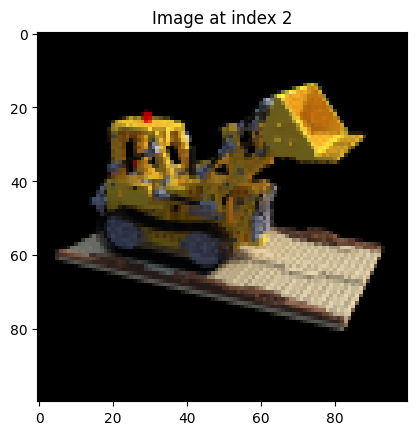

In [106]:
data =  np.load("../data/tiny_nerf_data.npz")
images, c2ws, focal = data["images"], data["poses"], data["focal"]

print(
    f"Shapes:",
    f"{images.shape=}",
    f"{c2ws.shape=}",
    f"{focal.shape=}",
    sep='\n  ',
)

plt.imshow(images[2])
plt.title("Image at index 2")

print(f"C2W transform at index 2: \n", c2ws[2])

print(f"Focal length: {focal:.4f}")

images = torch.from_numpy(images)
c2ws = torch.from_numpy(c2ws)
focal = torch.from_numpy(focal)

## Utility functions

To be exported into `ROOT_DIR/src/utils/`

In [107]:
def create_rays(height, width, intrinsic, c2w):
    focal_x = intrinsic[0, 0]
    focal_y = intrinsic[1, 1]
    # cx and cy handle the misalignement of the principal point with the center of the image
    cx = intrinsic[0, 2]
    cy = intrinsic[1, 2]

    # Index each point on the image, determine ray directions to them
    i, j = torch.meshgrid(torch.arange(width, dtype=torch.float32), torch.arange(height, dtype=torch.float32), indexing='xy')
    directions = torch.stack((
        (i - cx) / focal_x,
        -(j - cy) / focal_y,
        -torch.ones(i.shape, dtype=torch.float32)  # -1 since ray is cast away from camera
    ), -1)

    # Transform ray directions to World, origins just need to be broadcasted accordingly
    ray_directions = directions @ c2w[:3, :3].T
    ray_origins = torch.broadcast_to(c2w[:3, -1], ray_directions.shape)  # c2w last column determines position
    
    return ray_origins, ray_directions


# Test on real data
ex_index = 2
ex_img = images[ex_index]
ex_intr = torch.tensor([
    [focal.item(), 0, ex_img.shape[1] // 2],
    [0, focal.item(), ex_img.shape[0] // 2],
    [0, 0, 1],
], dtype=torch.float32)

origins, directions = create_rays(ex_img.shape[0], ex_img.shape[1], ex_intr, c2ws[ex_index])

"""
# Test on example data
ex_intr = torch.tensor([
    [4, 0, 5 // 2],
    [0, 4, 5 // 2],
    [0, 0, 1],
], dtype=torch.float32)

ex_c2w = torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 1],
    [0, 0, 0, 1],
], dtype=torch.float32)

o, d = create_rays(5, 5, ex_intr, ex_c2w)
"""

print(f"{origins.shape=} | {directions.shape=}")

origins.shape=torch.Size([100, 100, 3]) | directions.shape=torch.Size([100, 100, 3])


In [108]:
def create_nerf_data(images, c2ws, focal):
    rays = []
    colors = []

    # Collecting to list then concat for ease
    for image, c2w in zip(images, c2ws):
        intrinsic = torch.tensor([
            [focal.item(), 0, image.shape[1] // 2],
            [0, focal.item(), image.shape[0] // 2],
            [0, 0, 1],
        ], dtype=torch.float32)

        origins, directions = create_rays(image.shape[0], image.shape[1], intrinsic, c2w)

        data = torch.stack([origins, directions], dim=2)
        rays.append(data.flatten(0, 1))
        colors.append(image.flatten(0, 1))
        # shape(height * width, 1+1+1, 3) {1+1+1===origin, direction, rgb}

    rays = torch.cat(rays, dim=0)
    colors = torch.cat(colors, dim=0)
    return rays, colors

rays, colors = create_nerf_data(images, c2ws, focal)

print(f"{rays.shape=} | {colors.shape=}")
print(f"Training rays' size:   {rays.element_size() * rays.nelement() / (1024**2):.2f} MB")
print(f"Training images' size: {colors.element_size() * colors.nelement() / (1024**2):.2f} MB")

rays.shape=torch.Size([1060000, 2, 3]) | colors.shape=torch.Size([1060000, 3])
Training rays' size:   24.26 MB
Training images' size: 12.13 MB


In [109]:
class PositionalEncoding(nn.Module):
    # Appended Positional Encoding Module

    def __init__(self, max_freq: int):
        super(PositionalEncoding, self).__init__()
        self._max_freq = max_freq
        self._freq_bands = 2.0 ** torch.linspace(0.0, max_freq - 1, steps=max_freq, dtype=torch.float32)
    
    def forward(self, x):
        encs = (x[..., None] * self._freq_bands).flatten(-2, -1)
        # Encoding to (x, sin parts, cos parts) of shape(N, M+M*max_freq*2) if x is of shape(N,M)
        return torch.cat([x, encs.sin(), encs.cos()], dim=-1)
    
    def get_out_dim(self, in_dim):
        return in_dim + in_dim * self._max_freq * 2
    
enc = PositionalEncoding(10)
print(f"Output dimension: {enc.get_out_dim(3)}")
enc(rays[:1000, 1, :]).shape

Output dimension: 63


torch.Size([1000, 63])

In [110]:
def sample_ray_uniformally(origins, directions, near, far, num_samples, perturb=True):
    depths = torch.linspace(near, far, num_samples, dtype=torch.float32).expand(origins.shape[0], -1)
    if perturb:
        # Noise is at most half of step size
        noise = (torch.rand(depths.shape) - 0.5) * (far - near) / num_samples / 2
        # Clamping to stay between near and far
        depths = (depths + noise).clamp(near, far)
    
    points = origins[..., None, :] + directions[..., None, :] * depths[..., :, None]
    # Expand directions to make NeRF input
    directions = directions[..., None, :].expand(points.shape)
    return points, directions, depths

points, directions, depths = sample_ray_uniformally(rays[:50, 0], rays[:50, 1], 0.0, 10.0, 64)
print(f"{points.shape=} | {directions.shape=} | {depths.shape=}")

points.shape=torch.Size([50, 64, 3]) | directions.shape=torch.Size([50, 64, 3]) | depths.shape=torch.Size([50, 64])


In [111]:
class NeRF(nn.Module):
    def __init__(self, num_layers=8, hidden_size=256, in_coordinates=3, in_directions=3,
                 skips=[4], coord_encode_freq=10, dir_encode_freq=4):
        super(NeRF, self).__init__()
        self.in_coordinates = in_coordinates
        self.in_directions = in_directions
        self.skips = tuple(skips)

        self.coordinate_encoder = PositionalEncoding(coord_encode_freq)
        self.direction_encoder = PositionalEncoding(dir_encode_freq)

        coord_dim = self.coordinate_encoder.get_out_dim(self.in_coordinates)
        self.feature_mlp = nn.ModuleList([nn.Linear(coord_dim, hidden_size)])
        # go until num_layers -1 as we already have the initial layer
        for i in range(num_layers - 1):
            self.feature_mlp.append(nn.Sequential(
                # skip with +1 as we already have the initial layer
                nn.Linear(hidden_size + (coord_dim if i+1 in self.skips else 0), hidden_size),
                nn.ReLU(inplace=True),
            ))

        self.sigma_fc = nn.Linear(hidden_size, 1)

        self.color_preproc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(inplace=True),
        )
        dir_dim = self.direction_encoder.get_out_dim(self.in_directions)
        self.rgb_mlp = nn.Sequential(
            nn.Linear(hidden_size + dir_dim, hidden_size // 2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size // 2, 3),
            nn.ReLU(inplace=True),
        )

    def forward(self, coordinates, directions, skip_colors=False):
        coordinates = self.coordinate_encoder(coordinates)

        features = coordinates
        for i, fc in enumerate(self.feature_mlp):
            if i in self.skips:
                features = torch.cat([features, coordinates], -1)
            features = fc(features)

        sigma = self.sigma_fc(features)

        if skip_colors:
            return sigma

        directions = self.direction_encoder(directions)
        rgb = self.color_preproc(features)
        rgb = torch.cat([rgb, directions], dim=-1)
        rgb = self.rgb_mlp(rgb)

        return torch.cat([rgb, sigma], dim=-1)
    

NeRF()(points, directions).shape

torch.Size([50, 64, 4])